# [Latest advancements in AI-2019 to predict stock market movements] (https://github.com/borisbanushev/stockpredictionai)


 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this notebook I will create a complete process for predicting stock price movements. Follow along and we will achieve some pretty good results. For that purpose we will use a **Generative Adversarial Network** (GAN) with **LSTM**, a type of Recurrent Neural Network, as generator, and a Convolutional Neural Network, **CNN**, as a discriminator. We use LSTM for the obvious reason that we are trying to predict time series data. Why we use GAN and specifically CNN as a discriminator? That is a good question: there are special sections on that later.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will go into greater details for each step, of course, but the most difficult part is the GAN: very tricky part of successfully training a GAN is getting the right set of hyperparameters. For that reason we will use **Bayesian optimisation** (along with Gaussian processes) and **Reinforcement learning** (RL) for deciding when and how to change the GAN's hyperparameters (the exploration vs. exploitation dilemma). In creating the reinforcement learning we will use the most recent advancements in the field, such as **Rainbow** and **PPO**.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will use a lot of different types of input data. Along with the stock's historical trading data and technical indicators, we will use the newest advancements in **NLP** (using 'Bidirectional Embedding Representations from Transformers', **BERT**, sort of a transfer learning for NLP) to create sentiment analysis (as a source for fundamental analysis), **Fourier transforms** for extracting overall trend directions, **Stacked autoencoders** for identifying other high-level features, **Eigen portfolios** for finding correlated assets, autoregressive integrated moving average (**ARIMA**) for the stock function approximation, and many more, in order to capture as much information, patterns, dependencies, etc, as possible about the stock. As we all know, the more (data) the merrier. Predicting stock price movements is an extremely complex task, so the more we know about the stock (from different perspectives) the higher our changes are.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For the purpose of creating all neural nets we will use MXNet and its high-level API - Gluon, and train them on multiple GPUs.|



** Overall architecture **
<img src='https://github.com/borisbanushev/stockpredictionai/raw/master/imgs/main.jpg'>


# 1. Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Accurately predicting the stock markets is a complex task as there are millions of events and pre-conditions for a particilar stock to move in a particular direction. So we need to be able to capture as many of these pre-conditions as possible. We also need make several important assumptions: 1) markets are not 100% random, 2) history repeats, 3) markets follow people's rational behavior, and 4) the markets are '_perfect_'. And, please, do read the **Disclaimer** at the <a href="#disclaimer">bottom</a>.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will try to predict the price movements of **Goldman Sachs** (NYSE: GS). For the purpose, we will use daily closing price from January 1st, 2010 to December 31st, 2018 (seven years for training purposes and two years for validation purposes). _We will use the terms 'Goldman Sachs' and 'GS' interchangeably_


# 1. Resources
* A deep learning framework for financial time series using stacked autoencoders and long-short term memory: [(article)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944)
* Analysis of Financial Time-Series using Fourier and Wavelet
Methods: [(article)](https://pdfs.semanticscholar.org/1fc6/add45a68abe2927e83d7d44ebef6b40c130d.pdf)
* A Comparison Between Haar Wavelet Transform and Fast Fourier Transform in Analyzing Financial Time Series Data: [(article)](https://www.researchgate.net/publication/268993958_A_Comparison_Between_Haar_Wavelet_Transform_and_Fast_Fourier_Transform_in_Analyzing_Financial_Time_Series_Data)
* Understanding Variational Autoencoders (VAEs): [(article)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
* Is Joint Training Better for Deep Auto-Encoders? [(article)](https://arxiv.org/pdf/1405.1380.pdf)
* The erroneous use of the Haar wavelet transform for stock price prediction. [(article)](https://www.researchgate.net/publication/315476226_The_erroneous_use_of_the_Haar_wavelet_transform_for_stock_price_prediction)
* Can LSTM + WT + SAE get us to 82.5% annual returns on the Dow? [(article)](https://hackernoon.com/can-lstm-wt-sae-get-us-to-82-5-annual-returns-on-the-dow-89cd7637eb65)

# 3. The Data <a class="anchor" id="thedata"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We need to understand what affects whether GS's stock price will move up or down. It is what people as a whole think. Hence, we need to incorporate as much information (depicting the stock from different aspects and angles) as possible. (We will use daily data - 1,585 days to train the various algorithms (70% of the data we have) and predict the next 680 days (test data). Then we will compare the predicted results with a test (hold-out) data. Each type of data (we will refer to it as _feature_) is explained in greater detail in later sections, but, as a high level overview, the features we will use are:

1. **Correlated assets** - these are other assets (any type, not necessarily stocks, such as commodities, FX, indices, or even fixed income securities). A big company, such as Goldman Sachs, obviously doesn't 'live' in an isolated world - it depends on, and interacts with, many external factors, including its competitors, clients, the global economy, the geo-political situation, fiscal and monetary policies, access to capital, etc. The details are listed later.
2. **Technical indicators** - a lot of investors follow technical indicators. We will include the most popular indicators as independent features. Among them - 7 and 21 days moving average, exponential moving average, momentum, Bollinger bands, MACD.
3. **Fundamental analysis** - A very important feature indicating whether a stock might move up or down. There are two features that can be used in fundamental analysis: 1) Analysing the company performance using 10-K and 10-Q reports, analysing ROE and P/E, etc (we will not use this), and 2) **News** - potentially news can indicate upcoming events that can potentially move the stock in certain direction. We will read all daily news for Goldman Sachs and extract whether the total sentiment about Goldman Sachs on that day is positive, neutral, or negative (as a score from 0 to 1). As many investors closely read the news and make investment decisions based (partially of course) on news, there is a somewhat high chance that if, say, the news for Goldman Sachs today are extremely positive the stock will surge tomorrow. _One crucial point, we will perform feature importance (meaning how indicative it is for the movement of GS) on absolutely every feature (including this one) later on and decide whether we will use it. More on that later_.<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For the purpose of creating accurate sentiment prediction we will use Neural Language Processing (**NLP**). We will use **BERT** - Google's recently announced NLP approach for transfer learning for sentiment classification stock news sentiment extraction.
4. **Fourier transforms** - Along with the daily closing price, we will create Fourier transforms in order to generalize several long- and short-term trends. Using these transforms we will eliminate a lot of noise (random walks) and create approximations of the real stock movement. Having trend approximations can help the LSTM network pick its prediction trends more accurately.
5. **Autoregressive Integrated Moving Average** (ARIMA) - This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let's add it and see if it comes off as an important predictive feature.
6. **Stacked autoencoders** - most of the aforementioned features (fundamental analysis, technical analysis, etc) were found by people after decades of research. But maybe we have missed something. Maybe there are hidden correlations that people cannot comprehend due to the enormous amount of data points, events, assets, charts, etc. With stacked autoencoders (type of neural networks) we can use the power of computers and probably find new types of features that affect stock movements. Even though we will not be able to understand these features in human language, we will use them in the GAN.
7. **Deep Unsupervised learning for anomaly detection in options pricing**. We will use one more feature - for every day we will add the price for 90-days call option on Goldman Sachs stock. Options pricing itself combines a lot of data. The price for options contract depends on the future value of the stock (analysts try to also predict the price in order to come up with the most accurate price for the call option). Using deep unsupervised learning (**Self-organized Maps**) we will try to spot anomalies in every day's pricing. Anomaly (such as a drastic change in pricing) might indicate an event that might be useful for the LSTM to learn the overall stock pattern.

Next, having so many features, we need to perform a couple of important steps:
1. Perform statistical checks for the 'quality' of the data. If the data we create is flawed, then no matter how sophisticated our algorithms are, the results will not be positive. The checks include making sure the data does not suffer from heteroskedasticity, multicollinearity, or serial correlation.
2. Create feature importance. If a feature (e.g. another stock or a technical indicator) has no explanatory power to the stock we want to predict, then there is no need for us to use it in the training of the neural nets. We will using **XGBoost** (eXtreme Gradient Boosting), a type of boosted tree regression algorithms.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As a final step of our data preparation, we will also create **Eigen portfolios** using Principal Component Analysis (**PCA**) in order to reduce the dimensionality of the features created from the autoencoders.


In [1]:
import time
import numpy as np
import yfinance as yf
import quantstats as qs
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

# extend pandas functionality with metrics, etc.
import ron.datasources.datasources as datasources
import ron.ai as ai
from ron.pandas import extend_pandas
extend_pandas()

# set plot interactive mode
plt.ion()

TRAINING_SIZE = 0.7


In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [3]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("datasources", "../src/datasources/datasources.py")
# datasources = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(datasources)

Data

In [4]:
SYMBOL = 'GS'
TICKER = yf.Ticker(SYMBOL)
df, report, log, errors = datasources.timeseries(SYMBOL, period='10y')
print(errors)
print(log)
report


                                0
First Index   2011-01-03 00:00:00
Last Index    2020-04-01 00:00:00
Series shape            (2328, 5)


,Open,High,Low,Close,Volume
Consecutive NaN,1,1,1,1,1
Total Zeros,0,0,0,0,0
AutoClean: Final NaN,0,0,0,0,0


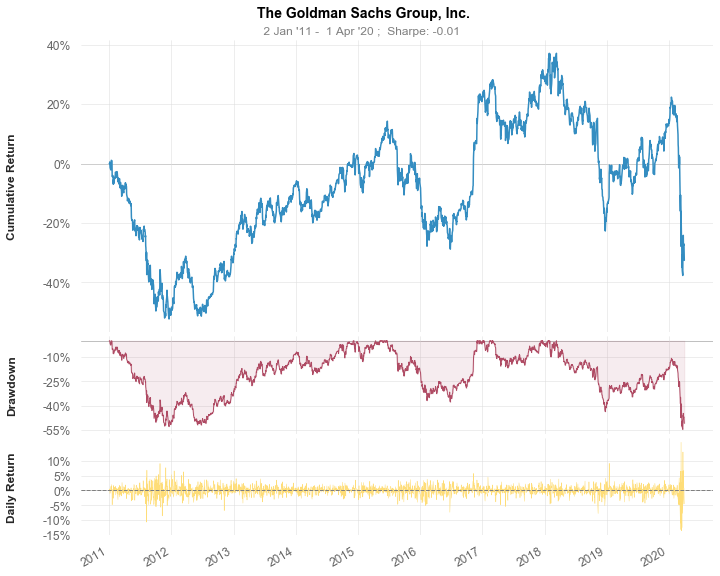

In [5]:
df_returns = df['Close'].log_returns()
df_returns.plot_snapshot(title=TICKER.info['longName'])


In [6]:
dataset_ex_df = df
data_size = len(dataset_ex_df)
num_training_days = int(data_size*TRAINING_SIZE)
num_test_days = data_size - num_training_days
print(f"Data size .   : {data_size} days")
print(f"Training size : {num_training_days} days")
print(f"Test size .   : {num_test_days} days")


Data size .   : 2327 days
Training size : 1628 days
Test size .   : 699 days


## 3.1. Correlated assets <a class="anchor" id="corrassets"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As explained earlier we will use other assets as features, not only GS.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;So what other assets would affect GS's stock movements? Good understanding of the company, its lines of businesses, competitive landscape, dependencies, suppliers and client type, etc is very important for picking the right set of correlated assets:
- First are the **companies** similar to GS. We will add JPMorgan Chase and Morgan Stanley, among others, to the dataset.
- As an investment bank, Goldman Sachs depends on the **global economy**. Bad or volatile economy means no M&As or IPOs, and possibly limited proprietary trading earnings. That is why we will include global economy indices. Also, we will include LIBOR (USD and GBP denominated) rate, as possibly shocks in the economy might be accounted for by analysts to set these rates, and other **FI** securities.
- Daily volatility index (**VIX**) - for the reason described in the previous point.
- **Composite indices** - such as NASDAQ and NYSE (from USA), FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices.
- **Currencies** - global trade is many times reflected into how currencies move, ergo we'll use a basket of currencies (such as USDJPY, GBPUSD, etc) as features.

#### Overall, we have 72 other assets in the dataset - daily price for every asset.


## 3.2. Technical indicators <a class="anchor" id="technicalind"></a>

We already covered what are technical indicators and why we use them so let's jump straight to the code. We will create technical indicators only for GS.

In [7]:
def add_technical_indicators(df, price_column='Close'):
    # Create 7 and 21 days Moving Average
    df['ma7'] = df[price_column].rolling(window=7).mean()
    df['ma21'] = df[price_column].rolling(window=21).mean()
    
    # Create MACD
    df['26ema'] = pd.Series.ewm(df[price_column], span=26).mean()
    df['12ema'] = pd.Series.ewm(df[price_column], span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])

    # Create Bollinger Bands
    df['20sd'] = df[price_column].rolling(20).std()
    df['upper_band'] = df['ma21'] + (df['20sd']*2)
    df['lower_band'] = df['ma21'] - (df['20sd']*2)
    
    # Create Exponential moving average
    df['ema'] = df[price_column].ewm(com=0.5).mean()
    
    # Create Momentum
    df['momentum'] = df[price_column]-1
    df['log_momentum'] = np.log(df['momentum'])
    
    return df

In [8]:
dataset_TI_df = add_technical_indicators(dataset_ex_df)
dataset_ex_df


,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,,,,,
2011-01-03,148.957925,151.316095,148.346550,151.141418,5717100.0,NaN,NaN,151.141418,151.141418,0.000000,NaN,NaN,NaN,151.141418,150.141418,5.011578
2011-01-04,151.857596,151.971142,150.224347,151.167618,3335500.0,NaN,NaN,151.155022,151.155610,0.000588,NaN,NaN,NaN,151.161068,150.167618,5.011752
2011-01-05,150.267978,152.399069,150.224306,151.971100,4140600.0,NaN,NaN,151.448231,151.473896,0.025665,NaN,NaN,NaN,151.721859,150.971100,5.017088
2011-01-06,152.416579,152.486453,150.206885,150.407776,5375200.0,NaN,NaN,151.157365,151.137363,-0.020002,NaN,NaN,NaN,150.834853,149.407776,5.006679
2011-01-07,150.835678,151.001625,147.918535,149.080154,4916100.0,NaN,NaN,150.675651,150.578427,-0.097224,NaN,NaN,NaN,149.660220,148.080154,4.997754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,156.369995,167.660004,154.309998,165.789993,6762200.0,148.201431,172.672858,177.402165,159.545666,-17.856500,24.611215,221.895289,123.450427,161.460491,164.789993,5.104672
2020-03-27,159.080002,163.729996,157.000000,158.339996,4186700.0,150.818573,170.477620,175.990153,159.360178,-16.629975,23.730620,217.938860,123.016379,159.380161,157.339996,5.058409
2020-03-30,158.520004,160.429993,153.179993,159.619995,4152800.0,152.265714,168.518095,174.777549,159.400150,-15.377399,21.790785,212.099666,124.936525,159.540051,158.619995,5.066511


So we have the technical indicators (including MACD, Bollinger bands, etc) for every trading day. We have in total 12 technical indicators.

Let's visualize the last 400 days of these indicators.

In [9]:
dataset = dataset_ex_df
shape_0 = dataset.shape[0]
xmacd_ = shape_0-400
dataset.index[0]


Timestamp('2011-01-03 00:00:00')

In [10]:
def plot_technical_indicators(dataset, last_days, price_column='Close'):
    plt.figure(figsize=(16, 10), dpi=100)
    dataset = dataset.iloc[-last_days:, :]

    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[price_column],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    shape_0 = dataset.index[0]
    xmacd_ = dataset.index[-1]
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

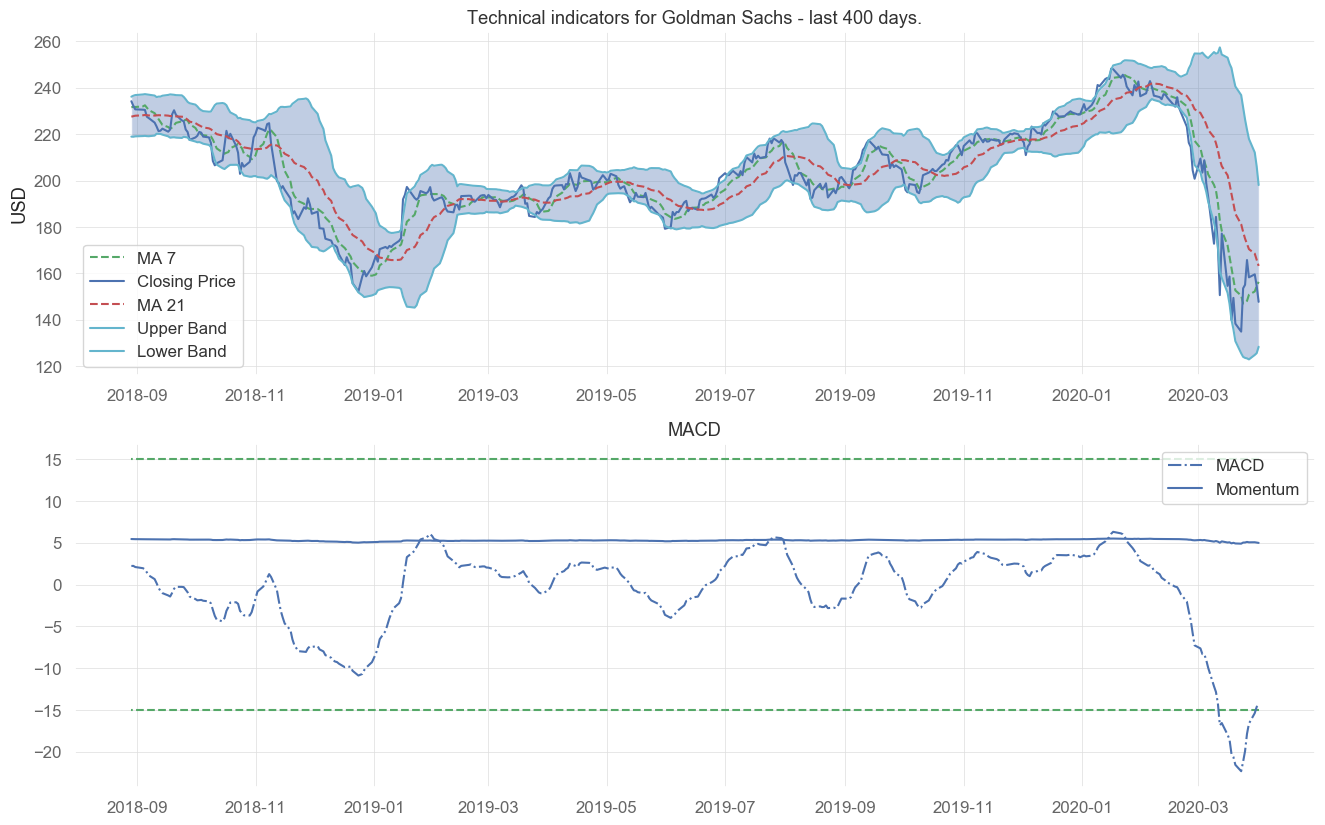

In [11]:
plot_technical_indicators(dataset_TI_df, 400)

### 3.3.1. Bidirectional Embedding Representations from Transformers - BERT <a class="anchor" id="bidirnlp"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For the purpose of classifying news as positive or negative (or neutral) we will use <a href="https://arxiv.org/abs/1810.04805">BERT</a>, which is a pre-trained language representation.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pretrained BERT models are already available in MXNet/Gluon. We just need to instantiated them and add two (arbitrary number) ```Dense``` layers, going to softmax - the score is from 0 to 1.

In [12]:
# just import bert
import bert

## 3.4. Fourier transforms for trend analysis <a class="anchor" id="fouriertransform"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Fourier transforms** take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function. Mathematically speaking, the transforms look like this:

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will use Fourier transforms to extract global and local trends in the GS stock, and to also denoise it a little. So let's see how it works.

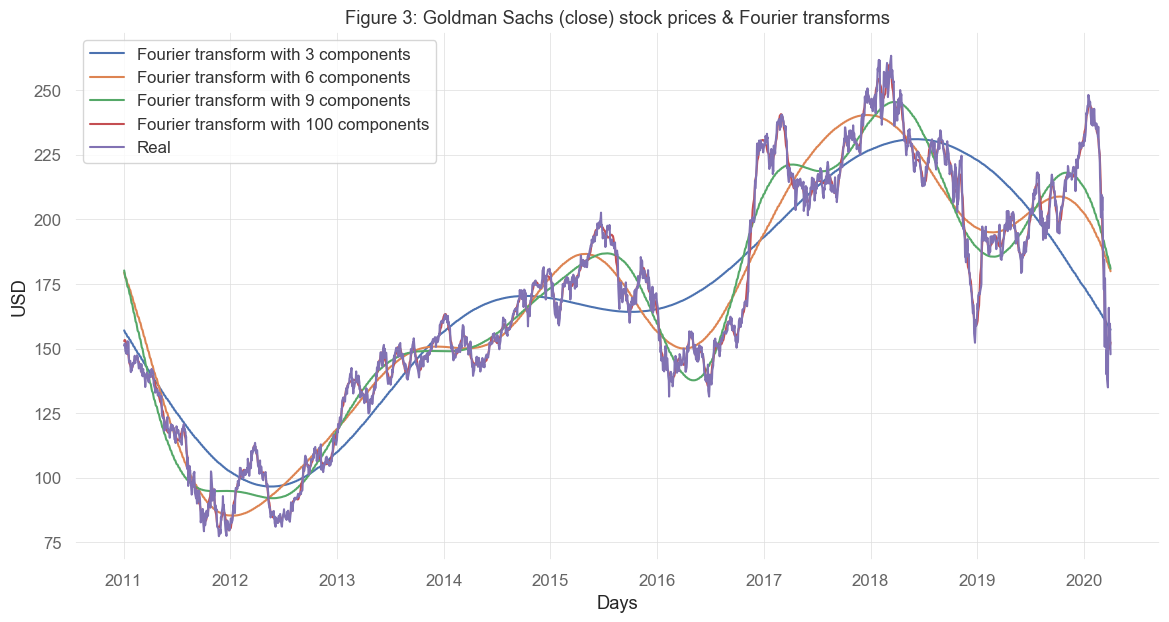

In [13]:
data_FT = dataset_ex_df[['Close']]

close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    data_FT['ifft'] = np.fft.ifft(fft_list_m10)
    plt.plot(data_FT['ifft'], label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

As you see in Figure 3 the more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap). We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Another technique used to denoise data is call **wavelets**. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.

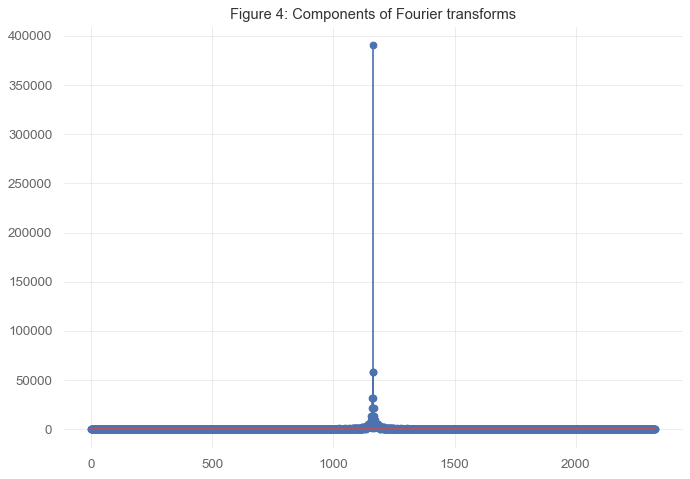

In [14]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## 3.5. ARIMA as a feature <a class="anchor" id="arimafeature"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ARIMA** is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.


In [15]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2326
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5715.458
Method:                       css-mle   S.D. of innovations              2.824
Date:                Sat, 04 Apr 2020   AIC                          11444.916
Time:                        13:26:21   BIC                          11485.179
Sample:                             1   HQIC                         11459.587
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0014      0.057     -0.025      0.980      -0.113       0.110
ar.L1.D.Close    -0.0881      0.021     -4.247      0.000      -0.129      -0.047
ar.L2.D.Close     0.0707      0.021      3.390      0.001       0.030

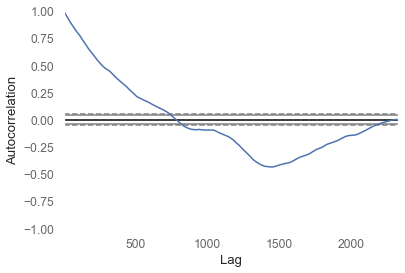

<Figure size 800x560 with 0 Axes>

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [17]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 14.342


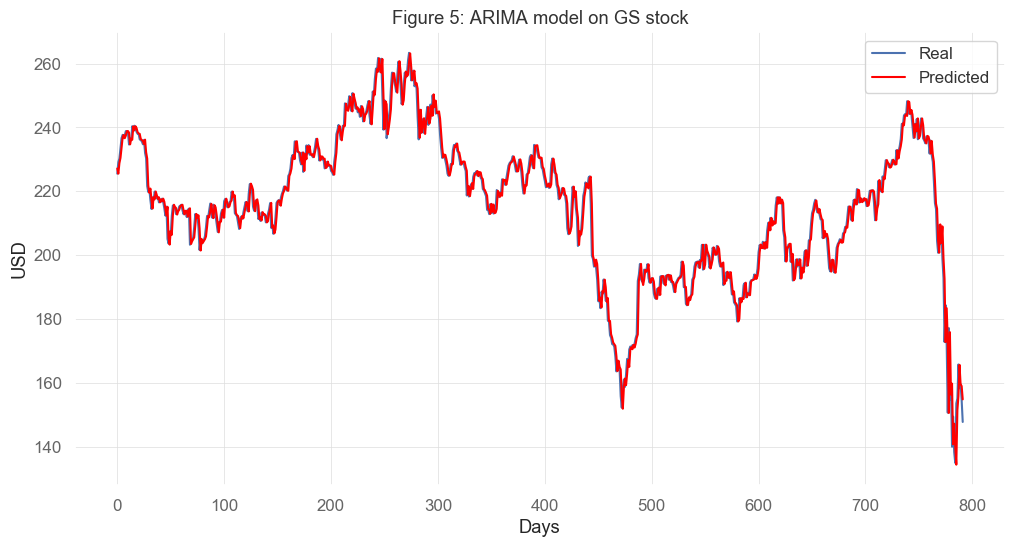

In [18]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Goldman Sachs as possible. We go test MSE (mean squared error) of 10.151, which by itself is not a bad result (considering we do have a lot of test data), but still we will only use it as a feature in the LSTM.

## 3.6. Statistical checks <a class="anchor" id="statchecks"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ensuring that the data has good quality is very important for out models. In order to make sure our data is suitable we will perform a couple of simple checks in order to ensure that the results we achieve and observe are indeed real, rather than compromised due to the fact that the underlying data distribution suffers from fundamental errors.

### 3.6.1. Heteroskedasticity, multicollinearity, serial correlation <a class="anchor" id="hetemultiser"></a>

- **Conditional Heteroskedasticity** occurs when the error terms (the difference between a predicted value by a regression and the real value) are dependent on the data - for example, the error terms grow when the data point (along the x-axis) grow.
- **Multicollinearity** is when error terms (also called residuals) depend on each other.
- **Serial correlation** is when one data (feature) is a formula (or completely depemnds) of another feature.

We will not go into the code here as it is straightforward and our focus is more on the deep learning parts, **but the data is qualitative**.

## 3.7. Feature Engineering <a class="anchor" id="featureeng"></a>
  So, after adding all types of data (the correlated assets, technical indicators, fundamental analysis, Fourier, and Arima) we have a total of 112 features for the 2,265 days (as mentioned before, however, only 1,585 days are for training data).

We will also have some more features generated from the autoencoders.

In [19]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

NameError: name 'dataset_total_df' is not defined


### 3.7.1. Feature importance with XGBoost <a class="anchor" id="xgboost"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Having so many features we have to consider whether all of them are really indicative of the direction GS stock will take. For example, we included USD denominated LIBOR rates in the dataset because we think that changes in LIBOR might indicate changes in the economy, that, in turn, might indicate changes in the GS's stock behavior. But we need to test. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since the features dataset is quite large, for the purpose of presentation here we'll use only the technical indicators. During the real features importance testing all selected features proved somewhat important so we won't exclude anything when training the GAN.

In [20]:
def get_feature_importance_data(data_income, price_column='Close'):
    data = data_income.copy()
    y = data[price_column]
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [21]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [22]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

eval_result = regressor.evals_result()

training_rounds = range(len(eval_result['validation_0']['rmse']))


[13:27:52] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Let's plot the training and validation errors in order to observe the training and check for overfitting (there isn't overfitting).

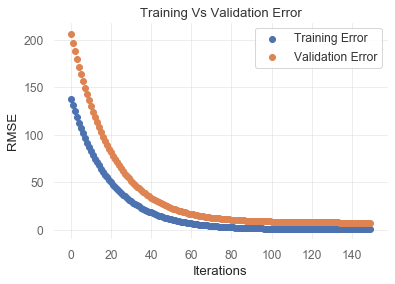

In [23]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

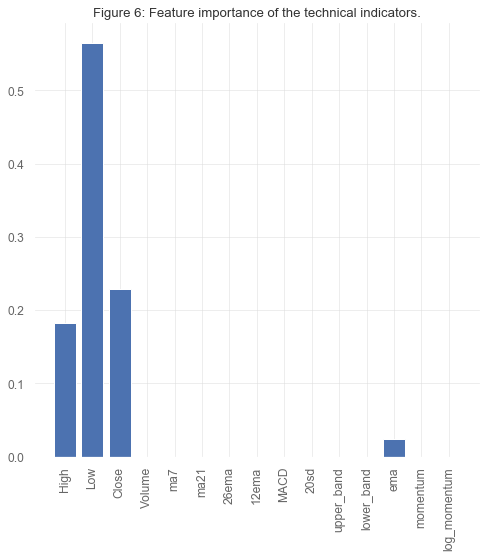

In [24]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

Not surprisingly (for those with experience in stock trading) that MA7, MACD, and BB are among the important features. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I followed the same logic for performing feature importance over the whole dataset - just the training took longer and results were a little more difficult to read, as compared with just a handful of features.

## 3.8. Extracting high-level features with Stacked Autoencoders <a class="anchor" id="stacked_ae"></a>

Before we proceed to the autoencoders, we'll explore an alternative activation function.

### 3.8.1. Activation function - GELU (Gaussian Error) <a class="anchor" id="gelu"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**GELU** - Gaussian Error Linear Unites was recently proposed - <a href="https://arxiv.org/pdf/1606.08415.pdf">link</a>. In the paper the authors show several instances in which neural networks using GELU outperform networks using ReLU as an activation. ```gelu``` is also used in **BERT**, the NLP approach we used for news sentiment analysis.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will use GELU for the autoencoders.

**Note**: The cell below shows the logic behind the math of GELU. It is not the actual implementation as an activation function. I had to implement GELU inside MXNet. If you follow the code and change ```act_type='relu'``` to ```act_type='gelu'``` it will not work, unless you change the implementation of MXNet. Make a pull request on the whole project to access the MXNet implementation of GELU.

In [25]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

Let's visualize GELU, ReLU, and LeakyReLU (the last one is mainly used in GANs - we also use it).

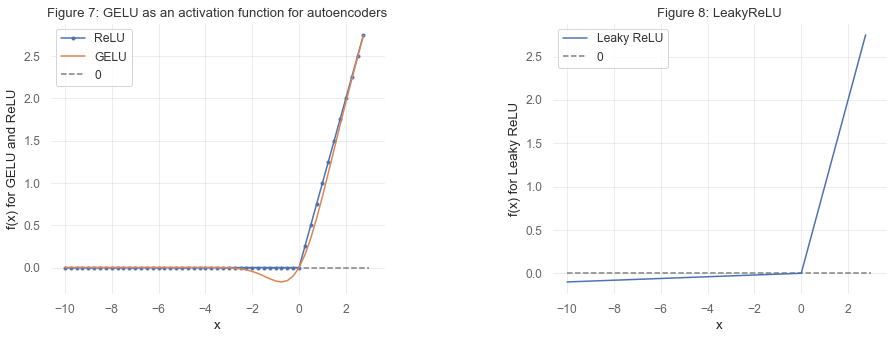

In [26]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

**Note**: In future versions of this notebook I will experiment using **U-Net** (<a href="https://arxiv.org/abs/1505.04597">link</a>), and try to utilize the convolutional layer and extract (and create) even more features about the stock's underlying movement patterns. For now, we will just use a simple autoencoder made only from ```Dense``` layers.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ok, back to the autoencoders, depicted below (the image is only schematic, it doesn't represent the real number of layers, units, etc.)

**Note**: One thing that I will explore in a later version is removing the last layer in the decoder. Normally, in autoencoders the number of encoders == number of decoders. We want, however, to extract higher level features (rather than creating the same input), so we can skip the last layer in the decoder. We achieve this creating the encoder and decoder with same number of layers during the training, but when we create the output we use the layer next to the only one as it would contain the higher level features.

<img src="https://github.com/borisbanushev/stockpredictionai/raw/master/imgs/VAE.jpg" width=428></img>

# Stacked Autoencoders

"The single-layer autoencoder maps the input daily variables into the first hidden vector."

"In this paper, [the activate function] is set to be a sigmoid function as in Chen et al. [19]"

"As a result, the gradient descent algorithm is applied to complete parameter optimization as suggested in Yin et al. [62]"

"After training the first single-layer autoencoder, the reconstruction layer of the first single layer autoencoder is removed, and the hidden layer is reserved as the input layer of the second single-layer autoencoder." (Bao et al., 2017, p. 7-8)

"SAEs is the main part of the model and is used to learn the deep features of financial time series in an unsupervised manner. Specifically, it is a neural network consisting of multiple single layer autoencoders in which the output feature of each layer is wired to the inputs of the successive layer. The unsupervised training of SAEs is done one AE at a time by minimizing the error between the output data and the input data. As a result, the SAEs model can successfully learn invariant and abstract features [19]." (Bao et al., 2017, p.2)

### Implementation:
Stacked Autoencoder with 5 Layers that consists of 4-single layer autoencoders

* Input variables for each dataset range from 18-25 features
* Depth of 5, hidden layer size of 10
* Gradient descent for parameter optimization
* Unsupervised training
* 100 Epochs for training (Chen et al., 2014)

In [27]:
dataset_TI_df.head()

,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,,,,,
2011-01-03,148.957925,151.316095,148.346550,151.141418,5717100.0,NaN,NaN,151.141418,151.141418,0.000000,NaN,NaN,NaN,151.141418,150.141418,5.011578
2011-01-04,151.857596,151.971142,150.224347,151.167618,3335500.0,NaN,NaN,151.155022,151.155610,0.000588,NaN,NaN,NaN,151.161068,150.167618,5.011752
2011-01-05,150.267978,152.399069,150.224306,151.971100,4140600.0,NaN,NaN,151.448231,151.473896,0.025665,NaN,NaN,NaN,151.721859,150.971100,5.017088
2011-01-06,152.416579,152.486453,150.206885,150.407776,5375200.0,NaN,NaN,151.157365,151.137363,-0.020002,NaN,NaN,NaN,150.834853,149.407776,5.006679
2011-01-07,150.835678,151.001625,147.918535,149.080154,4916100.0,NaN,NaN,150.675651,150.578427,-0.097224,NaN,NaN,NaN,149.660220,148.080154,4.997754


In [28]:
sae_data = dataset_TI_df.last("24m")
print("sae_data shape:", sae_data.shape)

def get_keras_stacked_autoencoder(data):
    input_dim = data.shape[1]

    hidden_layer = input_dim / 2
    if input_dim > 14 and input_dim < 26:
        hidden_layer = 10
    
    # Layer 1 - Input Layer, SAE_1
    input_data = Input(shape=(input_dim,))
    encoded = Dense(hidden_layer, activation='sigmoid')(input_data)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Layer 2 - SAE_2
    encoded = Dense(hidden_layer, activation='sigmoid')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Layer 3 - SAE_3
    encoded = Dense(hidden_layer, activation='sigmoid')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Layer 4 - SAE_4
    encoded = Dense(hidden_layer, activation='sigmoid')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Layer 5 - SAE_5
    encoded = Dense(hidden_layer, activation='sigmoid')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer='sgd',loss='mse')
    return autoencoder

autoencoder = get_keras_stacked_autoencoder(sae_data)
autoencoder.summary()

sae_data shape: (484, 16)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_6 (Dense)              (Non

In [53]:
results = autoencoder.fit(sae_data, sae_data, epochs=100,verbose=2)

Epoch 1/100
 - 0s - loss: 736355380740.2314
Epoch 2/100
 - 0s - loss: 736355365033.2561
Epoch 3/100
 - 0s - loss: 736355370991.0745
Epoch 4/100
 - 0s - loss: 736355380198.6116
Epoch 5/100
 - 0s - loss: 736355374917.8181
Epoch 6/100
 - 0s - loss: 736355383448.3306
Epoch 7/100
 - 0s - loss: 736355371261.8844
Epoch 8/100
 - 0s - loss: 736355373699.1736
Epoch 9/100
 - 0s - loss: 736355375865.6530
Epoch 10/100
 - 0s - loss: 736355372615.9340
Epoch 11/100
 - 0s - loss: 736355383989.9504
Epoch 12/100
 - 0s - loss: 736355373699.1736
Epoch 13/100
 - 0s - loss: 736355385614.8099
Epoch 14/100
 - 0s - loss: 736355368012.1653
Epoch 15/100
 - 0s - loss: 736355380198.6116
Epoch 16/100
 - 0s - loss: 736355382365.0909
Epoch 17/100
 - 0s - loss: 736355371803.5042
Epoch 18/100
 - 0s - loss: 736355374240.7935
Epoch 19/100
 - 0s - loss: 736355378032.1322
Epoch 20/100
 - 0s - loss: 736355365574.8760
Epoch 21/100
 - 0s - loss: 736355382229.6859
Epoch 22/100
 - 0s - loss: 736355365033.2561
Epoch 23/100
 - 0s 

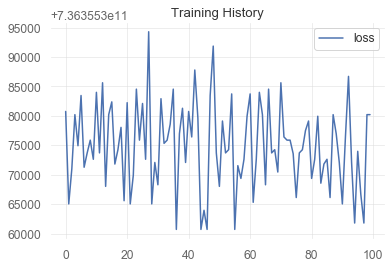

In [55]:
pd.DataFrame(results.history).plot(title="Training History")


In [79]:
sae_data.columns.values

array(['Open', 'High', 'Low', 'Close', 'Volume', 'ma7', 'ma21', '26ema',
       '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum'], dtype=object)

In [83]:
sae_encoded_data = pd.DataFrame(autoencoder.predict(sae_data))
sae_encoded_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.995811,0.995783,0.995732,0.995751,1.0,0.995757,0.995865,0.995872,0.99577,0.273066,0.720772,0.995994,0.995568,0.995791,0.995749,0.823259
1,0.995811,0.995783,0.995732,0.995751,1.0,0.995757,0.995865,0.995872,0.99577,0.273066,0.720772,0.995994,0.995568,0.995791,0.995749,0.823259
2,0.995811,0.995783,0.995732,0.995751,1.0,0.995757,0.995865,0.995872,0.99577,0.273066,0.720772,0.995994,0.995568,0.995791,0.995749,0.823259
3,0.995811,0.995783,0.995732,0.995751,1.0,0.995757,0.995865,0.995872,0.99577,0.273066,0.720772,0.995994,0.995568,0.995791,0.995749,0.823259
4,0.995811,0.995783,0.995732,0.995751,1.0,0.995757,0.995865,0.995872,0.99577,0.273066,0.720772,0.995994,0.995568,0.995791,0.995749,0.823259


### 3.8.1.1. Variational Autoencoders (VAE) <a class="anchor" id="gelu"></a>

Explanation on [Autoencoders](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

As a quick summary, VAE learns the parameters of the probability distribution modeling the input data, instead of learning an arbitrary function in the case of vanilla autoencoders. By sampling points from this distribution we can also use the VAE as a generative model. [Here](http://kvfrans.com/variational-autoencoders-explained/) is a good reference.

#### Note on Autoencoders
We have total control over the architecture of the autoencoder. We can make it very powerful by increasing the number of layers, nodes per layer and most importantly the code size. Increasing these hyperparameters will let the autoencoder to learn more complex codings. But we should be careful to not make it too powerful. Otherwise the autoencoder will simply learn to copy its inputs to the output, without learning any meaningful representation. It will just mimic the identity function. The autoencoder will reconstruct the training data perfectly, but it will be overfitting without being able to generalize to new instances, which is not what we want.
This is why we prefer a “sandwitch” architecture, and deliberately keep the code size small. Since the coding layer has a lower dimensionality than the input data, the autoencoder is said to be undercomplete. It won’t be able to directly copy its inputs to the output, and will be forced to learn intelligent features. If the input data has a pattern, for example the digit “1” usually contains a somewhat straight line and the digit “0” is circular, it will learn this fact and encode it in a more compact form. If the input data was completely random without any internal correlation or dependency, then an undercomplete autoencoder won’t be able to recover it perfectly.

In [29]:
VAE_data = dataset_TI_df # ASSUMPTION: CHECK THIS
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [30]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

CHANGE ACTIVATION BACK TO RELU AS GELU IS STILL NOT AVAILABLE ON MXNET 1.6.0

In [42]:
# ACTIVATION_FUNCTION = 'gelu'
ACTIVATION_FUNCTION = 'relu'


In [43]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type=ACTIVATION_FUNCTION)

net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 11, Activation(sigmoid))
  )
)


So we have 3 layers (with 400 neurons in each) in both the encoder and the decoder.


In [44]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Training completed in 73 seconds.


In [48]:
dataset_ex_df.shape

(5260, 12)

In [49]:
VAE_data.shape

(5260, 12)

In [51]:
net.summary

<bound method Block.summary of VAE(
  (encoder): HybridSequential(
    (0): Dense(11 -> 400, Activation(relu))
    (1): Dense(400 -> 400, Activation(relu))
    (2): Dense(400 -> 400, Activation(relu))
    (3): Dense(400 -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(2 -> 400, Activation(relu))
    (1): Dense(400 -> 400, Activation(relu))
    (2): Dense(400 -> 400, Activation(relu))
    (3): Dense(400 -> 11, Activation(sigmoid))
  )
)>